In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import VQ_VAE, Quantizer, LSTM_VQVAE, PixelCNN_VQVAE

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 64
dataset = torchvision.datasets.MNIST(root='.', download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = DataLoader(dataset, batch_size=BS,
                                         shuffle=True, num_workers=2)

device = torch.device('cuda')

In [3]:
with open('./VQ_VAE_parameters.yaml', 'rb') as f:
    config = yaml.safe_load(f)


In [4]:
criterion = nn.MSELoss()
beta_commitment = 0.2
lr = 0.005

model = VQ_VAE(config['model parameters'])
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = lr)

epochs = 10

In [5]:
losses = []
losses_embed = []
losses_reconstruction = []

model.train()
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch, _ in pbar:
        x = batch.to(device)
        x_hat, loss_embed, loss_commitment, _ = model(x)

        optim.zero_grad()
        loss_recon = criterion(x_hat, x)
        loss = loss_recon + loss_embed + beta_commitment * loss_commitment

        loss.backward()
        optim.step()

        losses.append(loss.item())
        losses_reconstruction.append(loss_recon.item())
        losses_embed.append(loss_embed.item())
        pbar.set_description(f'Loss: %.3f' % loss.item())



Loss: 0.178: 100%|██████████| 938/938 [00:33<00:00, 27.83it/s]


Text(0.5, 1.0, 'Losses plots')

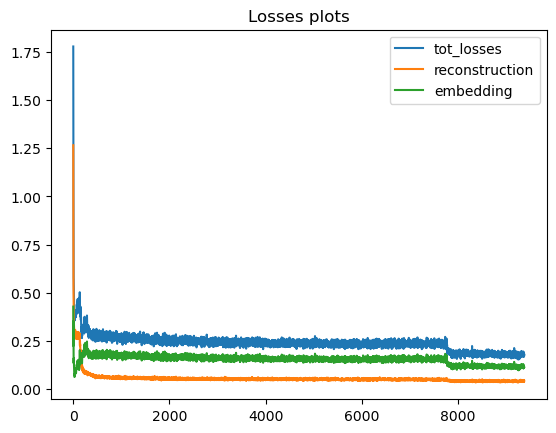

In [6]:
plot(losses, label = 'tot_losses')
plot(losses_reconstruction, label = 'reconstruction')
plot(losses_embed, label = 'embedding')
legend()
title('Losses plots')

In [8]:
#model.load_state_dict(torch.load('.\model_saves\VQVAE_MNIST.pth'))

<All keys matched successfully>

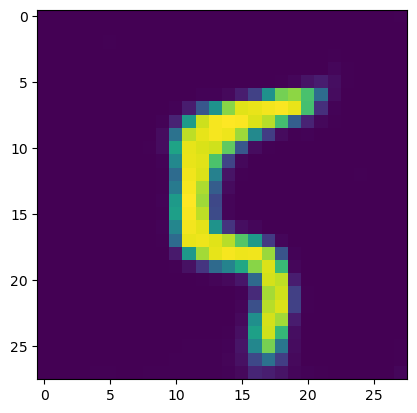

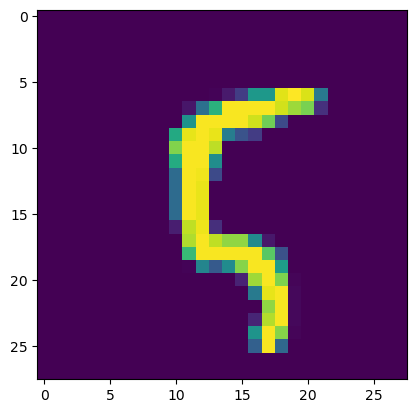

In [9]:
model.eval()
with torch.no_grad():
    imshow(model(dataloader.dataset[100][0].unsqueeze(0).to(device))[0].detach().cpu().numpy()[0,0])
    show()
    imshow(dataloader.dataset[100][0].numpy()[0])
    show()

In [10]:
with torch.no_grad():
    print(model(dataloader.dataset[1000][0].unsqueeze(0).to(device))[3].shape)

torch.Size([1, 36])


In [33]:
#torch.save(model.state_dict(), '.\model_saves\VQVAE_MNIST.pth')

# Generation using the VQ-VAE
For now, it is NOT possible, since we don't know the prior over the quantized latent space. We can reconstruct from any images passed through the encoder. Hence, we train a LSTM model to model the prior over the discrete latent space which will be useful to generate images.

## Create dataset for the LSTM by saving images encoded from the VQ-VAE

In [11]:
import pickle
to_save = None
model.eval()
with torch.no_grad():
    for im, _ in dataloader:
        im = im.to(device)
        _, _, _, quantized_idx = model(im)
        to_save = quantized_idx if to_save is None else torch.cat([to_save, quantized_idx], dim = 0)

    pickle.dump(to_save,open('./additional_datasets/mnist_quantized_encodings.pkl','wb'))

In [12]:

class MnistQuantizedEncoding(Dataset):
    def __init__(self, config, size_quant):
        self.size_codebook = config['model parameters']['size_codebook']
        self.size_quant = size_quant
        self.quantized = self.load_quantized()
    
    def load_quantized(self):
        mnist_encodings = pickle.load(open('./additional_datasets/mnist_quantized_encodings.pkl', 'rb'))
        mnist_encodings = mnist_encodings.reshape(mnist_encodings.size(0),self.size_quant, self.size_quant).unsqueeze(1)
        
        return mnist_encodings

    def __len__(self):
        return len(self.quantized)
    
    def __getitem__(self, index):
        context = self.quantized[index]
        return context

In [13]:
model.out_encoder_size

6

In [14]:
encodings_mnist = MnistQuantizedEncoding(config, model.out_encoder_size)
encodings_dataloader = DataLoader(encodings_mnist, batch_size=BS, shuffle = True)

In [15]:
pixel_cnn = PixelCNN_VQVAE(config['model parameters'])
pixel_cnn = pixel_cnn.to(device)

lr_lstm = 0.001
pixelcnn_optim = torch.optim.AdamW(pixel_cnn.parameters(), lr = lr_lstm)
criterion_pixelcnn = nn.CrossEntropyLoss()


In [16]:
losses_pixelcnn = []

pixel_cnn.train()
for _ in range(10):
    pixelcnn_pbar = tqdm.tqdm(encodings_dataloader)
    for x in pixelcnn_pbar:
        x = x.to(device).float()
        pixelcnn_optim.zero_grad()

        out = pixel_cnn(x)
        
        loss_pixelcnn = criterion_pixelcnn(out, x.long().squeeze(1))

        loss_pixelcnn.backward()
        pixelcnn_optim.step()

        losses_pixelcnn.append(loss_pixelcnn.item())
        pixelcnn_pbar.set_description('Loss PixelCNN: %.3f' % loss_pixelcnn.item())
        

Loss PixelCNN: 0.917: 100%|██████████| 938/938 [00:26<00:00, 35.20it/s]


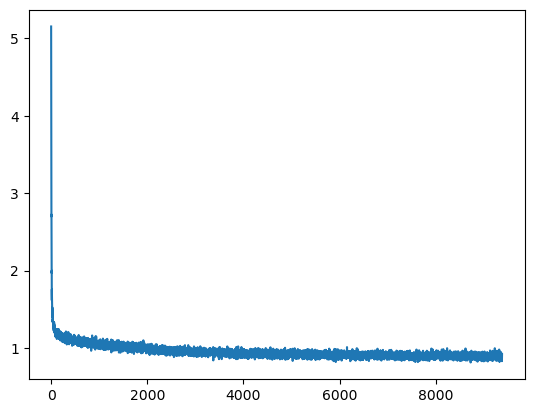

In [17]:
plot(losses_pixelcnn)

In [18]:
model.out_encoder_size

6

In [34]:
model.eval()
pixel_cnn.eval()
with torch.no_grad():
    quantized_batch = pixel_cnn.generate(nb_samples=100, img_size=model.out_encoder_size).long().squeeze(1)
    embedded_batch = model.quantizer.embedding(quantized_batch).permute(0,3,1,2)
    out = model.decoder(model.post_conv_quant(embedded_batch))
    out = (out+1)/2

In [35]:
grid = torchvision.utils.make_grid(out.cpu(), nrow = 10)

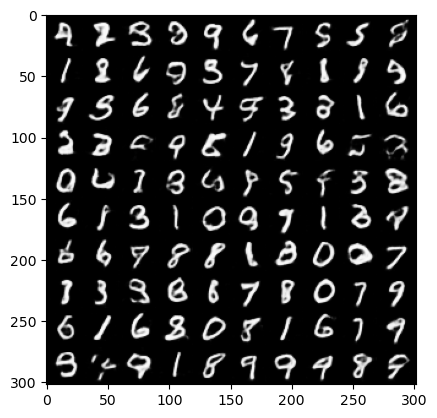

In [36]:
imshow(grid.permute(1,2,0))

In [37]:
#torchvision.utils.save_image(grid, './generate_pixelcnn_prior_VQVAE_2nd.png')

In [24]:
#torch.save(pixel_cnn.state_dict(), './model_saves/pixelcnn_prior_VQVAE.pt')
#pixel_cnn.load_state_dict(torch.load('./model_saves/pixelcnn_prior_VQVAE.pt'))

<All keys matched successfully>

In [12]:
'''
class MnistSeqDataset(Dataset):
    r"""
    Dataset for training of LSTM. Assumes the encodings are already generated
    by running vqvae inference
    """
    def __init__(self, config):
        self.size_codebook = config['model parameters']['size_codebook']
        
        # Codebook tokens will be 0 to size_codebook-1
        self.start_token = self.size_codebook
        self.pad_token = self.size_codebook+1
        # Fix context size
        self.context_size = 32
        self.sents = self.load_sents()
    
    def load_sents(self):
        mnist_encodings = pickle.load(open('./additional_datasets/mnist_quantized_encodings.pkl', 'rb'))
        mnist_encodings = mnist_encodings.reshape(mnist_encodings.size(0), -1)
        num_encodings = mnist_encodings.size(0)
        padded_sents = []
        
        for encoding_idx in tqdm.tqdm(range(num_encodings)):
            # Use only 10% encodings.
            # Uncomment this for getting some kind of output quickly validate working
            if random.random() > 0.1:
                continue
            enc = mnist_encodings[encoding_idx]
            encoding_length = enc.shape[-1]
            
            # Make sure all encodings start with start token
            enc = torch.cat([torch.ones((1)).to(device) * self.start_token, enc.to(device)])
            
            # Create batches of context sized inputs(if possible) and target
            sents = [(enc[:i], enc[i]) if i < self.context_size else (enc[i - self.context_size:i], enc[i])
                   for i in range(1, encoding_length+1)]
            
            for context, target in sents:
                # Pad token if context not enough
                if len(context) < self.context_size:
                    context = torch.nn.functional.pad(context, (0, self.context_size-len(context)), "constant", self.pad_token)
                padded_sents.append((context, target))
        return padded_sents
    
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, index):
        context, target = self.sents[index]
        return context, target'''

In [13]:
'''encodings_mnist = MnistSeqDataset(config)
encodings_dataloader = DataLoader(encodings_mnist, batch_size=BS, shuffle = True)
encodings_dataloader.dataset[0], encodings_dataloader.dataset[1]'''

100%|██████████| 60000/60000 [00:31<00:00, 1905.13it/s]


In [25]:
'''lstm_prior = LSTM_VQVAE(config['model parameters'])
lstm_prior = lstm_prior.to(device)

lr_lstm = 0.001
lstm_optim = torch.optim.AdamW(lstm_prior.parameters(), lr = lr_lstm)
criterion_lstm = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(lstm_optim,patience = 1000, verbose = True)'''

In [26]:
'''losses_lstm = []

lstm_prior.train()
for _ in range(10):
    lstm_pbar = tqdm.tqdm(encodings_dataloader)
    for x, y in lstm_pbar:
        x = x.to(device).long()
        y = y.to(device).long()
        lstm_optim.zero_grad()

        out = lstm_prior(x)
        
        loss_lstm = criterion_lstm(out, y)

        loss_lstm.backward()
        lstm_optim.step()

        losses_lstm.append(loss_lstm.item())

        #scheduler.step(loss_lstm)
        lstm_pbar.set_description('Loss lstm: %.3f' % loss_lstm.item())
plot(losses_lstm)
        '''

Loss lstm: 0.726: 100%|██████████| 3396/3396 [02:03<00:00, 27.60it/s]


In [29]:
'''model.eval()
lstm_prior.eval()
with torch.no_grad():
    quantized_idx = []
    encodings_len = model.out_encoder_size**2
    context_len = encodings_dataloader.dataset.context_size

    for _ in tqdm.tqdm(range(100)):
        seq = torch.ones(1).to(device)*lstm_prior.size_codebook

        for i in range(encodings_len):
            padded_seq = seq 
            if len(padded_seq) < context_len:
                padded_seq = nn.functional.pad(padded_seq, pad = (0,context_len-len(padded_seq)),value = lstm_prior.size_codebook)

            out = lstm_prior(padded_seq[-context_len:].unsqueeze(0).long().to(device))
            probs = F.softmax(out, dim = -1)

            idx = torch.multinomial(probs[0], num_samples = 1)

            seq = torch.cat([seq, idx])

        quantized_idx.append(seq[1:].unsqueeze(0))

    quantized_batch = torch.cat(quantized_idx, dim = 0)

    quantized_batch = quantized_batch.reshape(quantized_batch.shape[0], model.out_encoder_size,model.out_encoder_size).long()
    embedded_batch = model.quantizer.embedding(quantized_batch).permute(0,3,1,2)
    out = model.decoder(model.post_conv_quant(embedded_batch))
    out = (out+1)/2

    

'''

100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


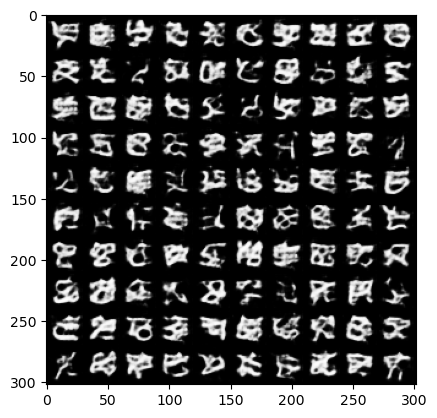

In [31]:
'''
grid = torchvision.utils.make_grid(out.cpu(), nrow=10)
imshow(grid.permute(1,2,0))
'''

In [32]:
#torch.save(lstm_prior.state_dict(), './model_saves/lstm_prior_MNIST.pth')

In [30]:
#lstm_prior.load_state_dict(torch.load('./model_saves/lstm_prior_MNIST.pth'))

<All keys matched successfully>